**Brain Cancer Detection using CNN and Unet Segmentation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from torch.utils.data import Dataset
from sklearn.utils import shuffle
from PIL import Image
from glob import glob # different image format can be used
from sklearn.metrics import accuracy_score,confusion_matrix
import cv2
import sys



from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")





Reading the images


In [ ]:
tumor = []
datafoler = '/content/drive/MyDrive/brain_tumor_dataset/yes'
for filename in os.listdir(datafoler):
  img = cv2.imread(os.path.join(datafoler,filename))
  img = cv2.resize(img,(128,128))
  b,g,r = cv2.split(img)
  img = cv2.merge([r,g,b])
  tumor.append(img)

len(tumor)

155

In [ ]:
for img in tumor:
  print(img.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

In [ ]:
healthy = []
datafoler = '/content/drive/MyDrive/brain_tumor_dataset/no'
for filename in os.listdir(datafoler):
  img = cv2.imread(os.path.join(datafoler,filename))
  img = cv2.resize(img,(128,128))
  b,g,r = cv2.split(img)
  img = cv2.merge([r,g,b])
  healthy.append(img)

len(healthy)

98

In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)

In [ ]:
tumor.shape


(155, 128, 128, 3)

In [ ]:
healthy.shape

(98, 128, 128, 3)

In [ ]:
ALL = np.concatenate((tumor,healthy))

In [ ]:
ALL.shape

(253, 128, 128, 3)

Visualizing Brain MRI Images


In [ ]:
def plot_random(healthy,tumor,num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0],num,replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0],num,replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')


        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])


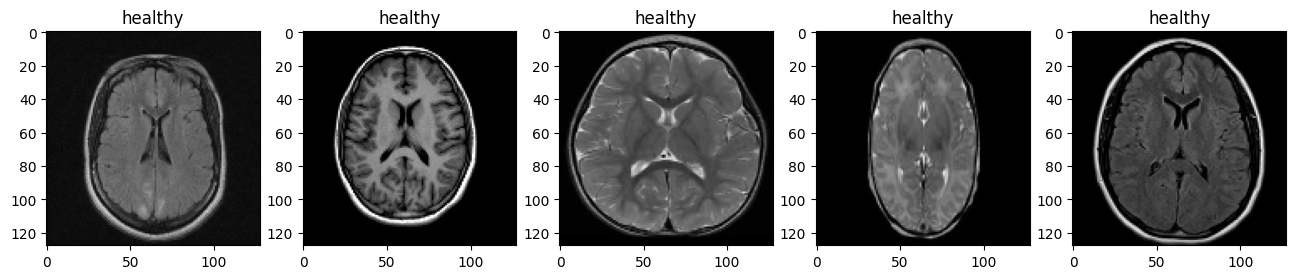

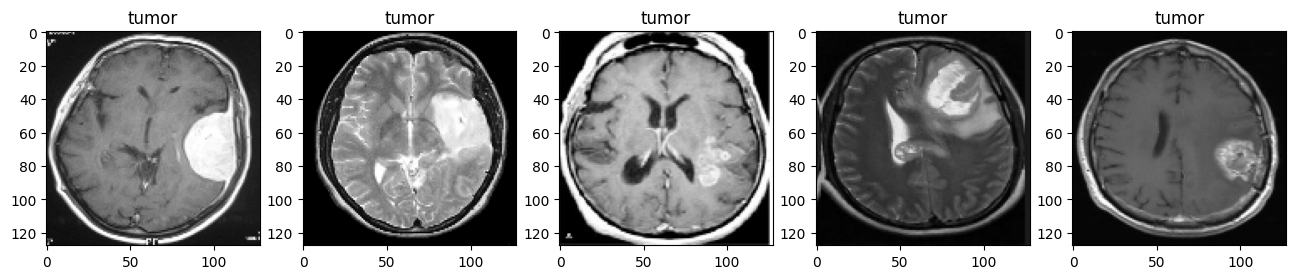

In [ ]:
plot_random(healthy,tumor)

Creating Torch Dataset Class

In [ ]:
class Dataset(object):

     def __getitem__(self, index):
        raise NotImplementedError

     def __len__(self):
        raise NotImplementedError

     def __add__(self, other):
        return ConcatDataset([self, other])


Creating MRI custom dataset class


In [ ]:
class MRI(Dataset):
  def __init__(self):
    tumor = []

    datafoler = '/content/drive/MyDrive/brain_tumor_dataset/yes'
    for filename in os.listdir(datafoler):
        img = cv2.imread(os.path.join(datafoler,filename))
        img = cv2.resize(img,(128,128))
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
        tumor.append(img)
    healthy = []
    datafoler = '/content/drive/MyDrive/brain_tumor_dataset/no'
    for filename in os.listdir(datafoler):
        img = cv2.imread(os.path.join(datafoler,filename))
        img = cv2.resize(img,(128,128))
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
        healthy.append(img)

  # our images
    tumor = np.array(tumor,dtype=np.float32)
    healthy = np.array(healthy,dtype=np.float32)

  # our labels
    tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
    healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

   # Concatenators
    self.images = np.concatenate((tumor, healthy), axis=0)
    self.labels = np.concatenate((tumor_label, healthy_label), axis=0)

 #   self.images = torch.from_numpy(self.images)
    self.labels = torch.from_numpy(self.labels)



  def __len__(self):
    return self.images.shape[0]


  def __getitem__(self,index):

    sample = {'image': self.images[index], 'label' : self.labels[index]}

    return sample

  def normalize(self):
    self.images = self.images / 255





In [ ]:
mri = MRI()
mri.normalize()

In [ ]:
img = mri[5]['image']

In [ ]:
img.shape

(3, 128, 128)

Creating a dataloader

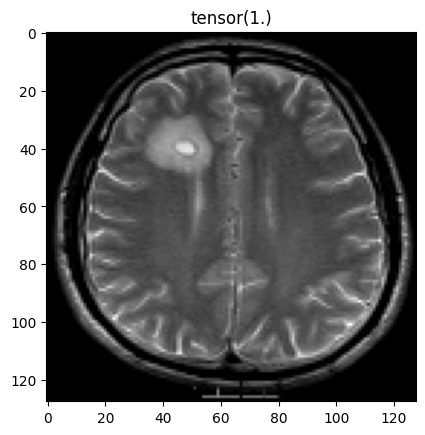

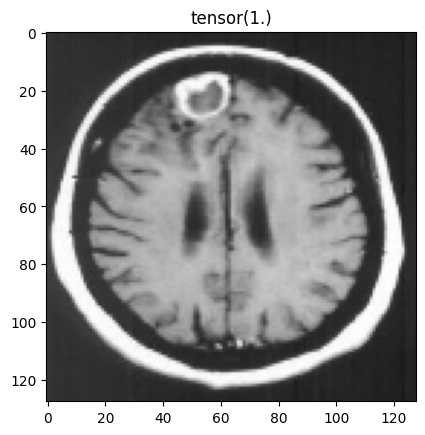

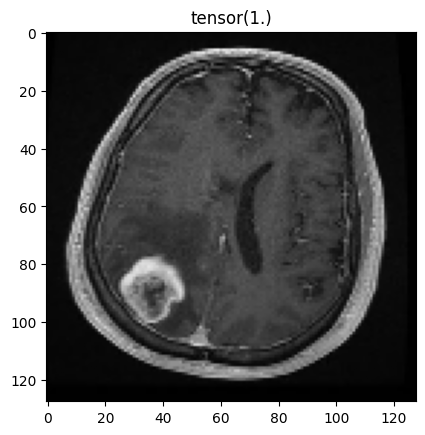

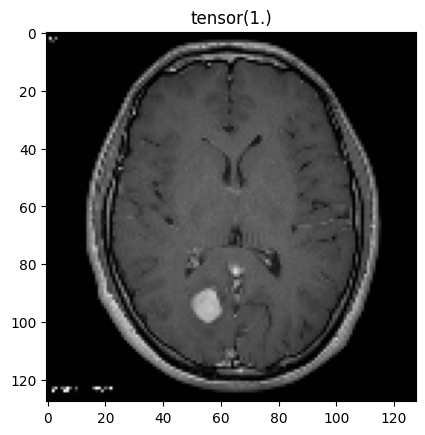

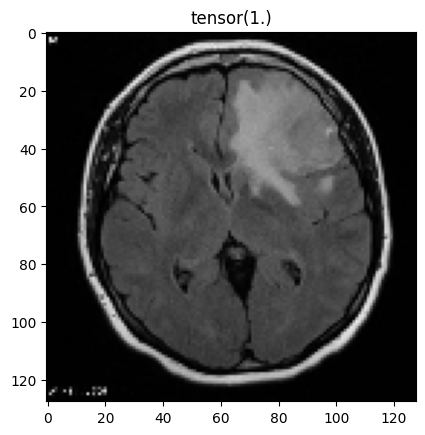

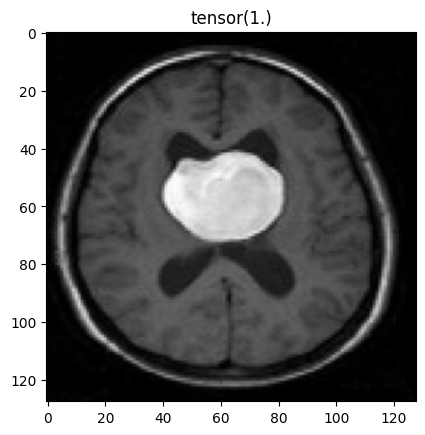

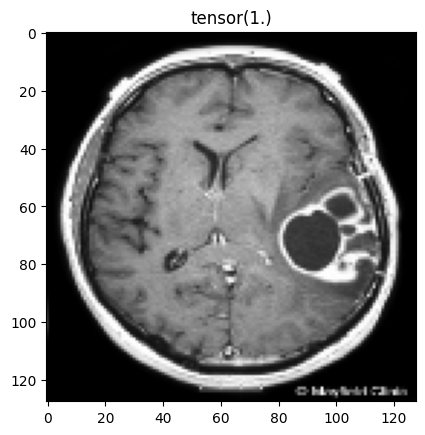

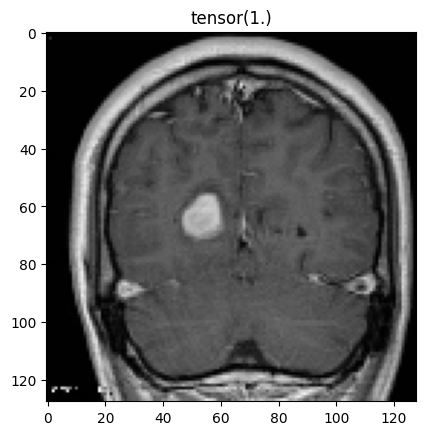

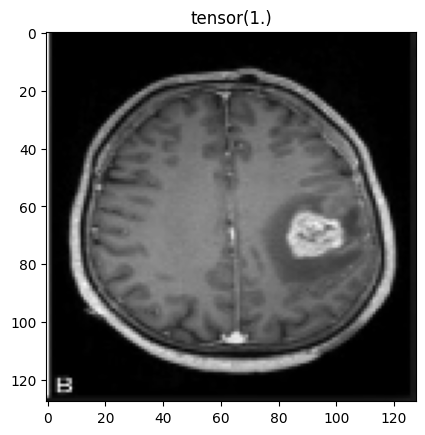

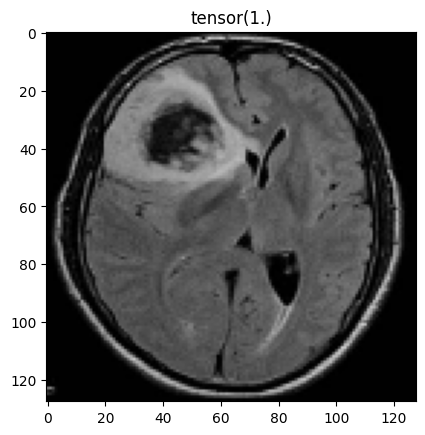

In [ ]:
it = iter(mri)
for i in range(10):
  sample = next(it)
  img = sample['image']
  label = sample['label']
  img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
  plt.title(label)
  plt.imshow(img)
  plt.show()

Dataloader

In [ ]:
dataloader = DataLoader(mri, batch_size=8, shuffle=True)

In [ ]:
for sample in dataloader:
    img = sample['image']
    print(img.shape)
    sys.exit()
 #   label = sample['label']
  #  img = img.reshape(img.shape[1], img.shape[0], img.shape[2])
   # plt.title(label)
    #plt.imshow(img)
    #plt.show()

torch.Size([8, 3, 128, 128])


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Model building

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class UNet_Classification(nn.Module):
    def __init__(self):
        super(UNet_Classification, self).__init__()

        # Encoder part (Contracting path)
        self.enc_conv1 = self.double_conv(3, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder part (Expanding path)
        self.up_conv4 = self.up_conv(1024, 512)
        self.dec_conv4 = self.double_conv(1024, 512)

        self.up_conv3 = self.up_conv(512, 256)
        self.dec_conv3 = self.double_conv(512, 256)

        self.up_conv2 = self.up_conv(256, 128)
        self.dec_conv2 = self.double_conv(256, 128)

        self.up_conv1 = self.up_conv(128, 64)
        self.dec_conv1 = self.double_conv(128, 64)

        # Replace final segmentation layer with fully connected layer for binary classification
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

        # Add adaptive average pooling to reduce the output to a single value
        self.pool = nn.AdaptiveAvgPool2d(1)  # Output shape will be [batch_size, 1, 1, 1]
        self.fc = nn.Linear(1, 1)  # Binary classification

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc_conv1(x)
        x = F.max_pool2d(enc1, kernel_size=2)

        enc2 = self.enc_conv2(x)
        x = F.max_pool2d(enc2, kernel_size=2)

        enc3 = self.enc_conv3(x)
        x = F.max_pool2d(enc3, kernel_size=2)

        enc4 = self.enc_conv4(x)
        x = F.max_pool2d(enc4, kernel_size=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        x = self.up_conv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec_conv4(x)

        x = self.up_conv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec_conv3(x)

        x = self.up_conv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec_conv2(x)

        x = self.up_conv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec_conv1(x)

        # Final convolution layer
        x = self.final_conv(x)

        # Adaptive average pooling to reduce the output to a single value
        x = self.pool(x)

        # Flatten the output to [batch_size, 1] for binary classification
        x = x.view(x.size(0), -1)

        # Fully connected layer
        output = torch.sigmoid(self.fc(x))  # Sigmoid for binary classification
        return output

# Instantiate the model
model = UNet_Classification().to(device)



Training model

In [ ]:
eta = 0.0001
EPOCHS = 140
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

criterion = nn.BCELoss()

for epoch in range(1, EPOCHS + 1):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        # Forward pass through the model
        y_hat = model(data)

        # Ensure label is of shape [batch_size, 1] for binary classification
        label = label.unsqueeze(1)

        # Calculate binary cross-entropy loss
        loss = criterion(y_hat, label)

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Print loss every 10 epochs
    if (epoch % 10) == 0:
        print(f'Train Epoch: {epoch}\tLoss: {np.mean(losses):.6f}')


Train Epoch: 10	Loss: 0.567760
Train Epoch: 20	Loss: 0.548963
Train Epoch: 30	Loss: 0.496783
Train Epoch: 40	Loss: 0.480179
Train Epoch: 50	Loss: 0.452115
Train Epoch: 60	Loss: 0.429130
Train Epoch: 70	Loss: 0.363227
Train Epoch: 80	Loss: 0.287414
Train Epoch: 90	Loss: 0.408857
Train Epoch: 100	Loss: 0.136377
Train Epoch: 110	Loss: 0.205635
Train Epoch: 120	Loss: 0.093806
Train Epoch: 130	Loss: 0.007070
Train Epoch: 140	Loss: 0.000024


Evaluating the model

In [ ]:
model.eval()
dataloader = DataLoader(mri, batch_size=8, shuffle=False)
outputs=[]
y_true=[]
with torch.no_grad():
     for D in dataloader:
         image = D['image'].to(device)
         label = D['label'].to(device)

         y_hat = model(image)

         outputs.append(y_hat.cpu().numpy())
         y_true.append(label.cpu().numpy())

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [ ]:
accuracy_score(y_true, np.round(outputs))

1.0

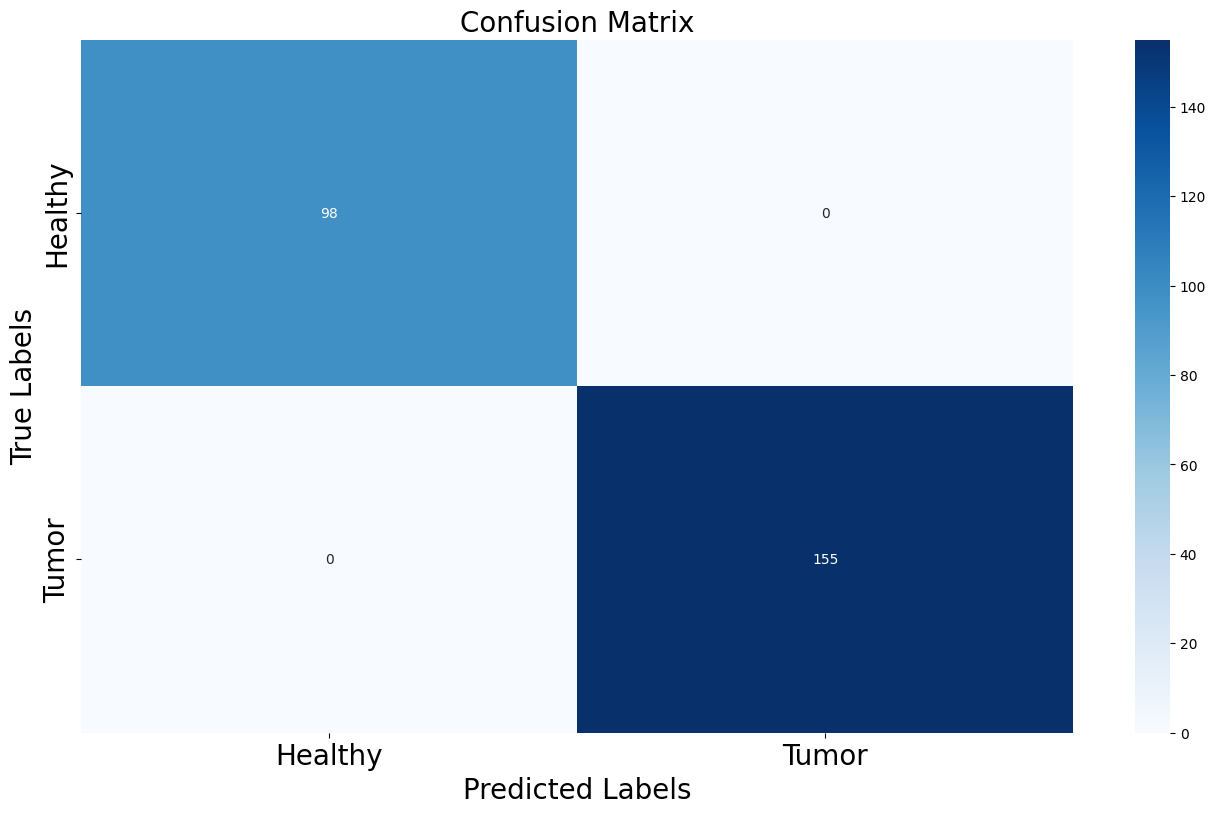

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example y_true and outputs (you need to define these)
# y_true = [list of true labels]
# outputs = [list of predicted values/probabilities]

# Apply threshold (assuming binary classification, with threshold of 0.5)
threshold_value = 0.5
y_pred = (outputs >= threshold_value).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define figure size
plt.figure(figsize=(16, 9))

# Create a subplot for heatmap
ax = plt.subplot()

# Plot the heatmap with annotations
sns.heatmap(cm, annot=True, cmap='Blues', fmt="d", ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)

# Customize tick labels (make sure these match your classification classes)
tick_labels = ['Healthy', 'Tumor']  # Adjust this based on your dataset
ax.xaxis.set_ticklabels(tick_labels, fontsize=20)
ax.yaxis.set_ticklabels(tick_labels, fontsize=20)

# Show the plot
plt.show()


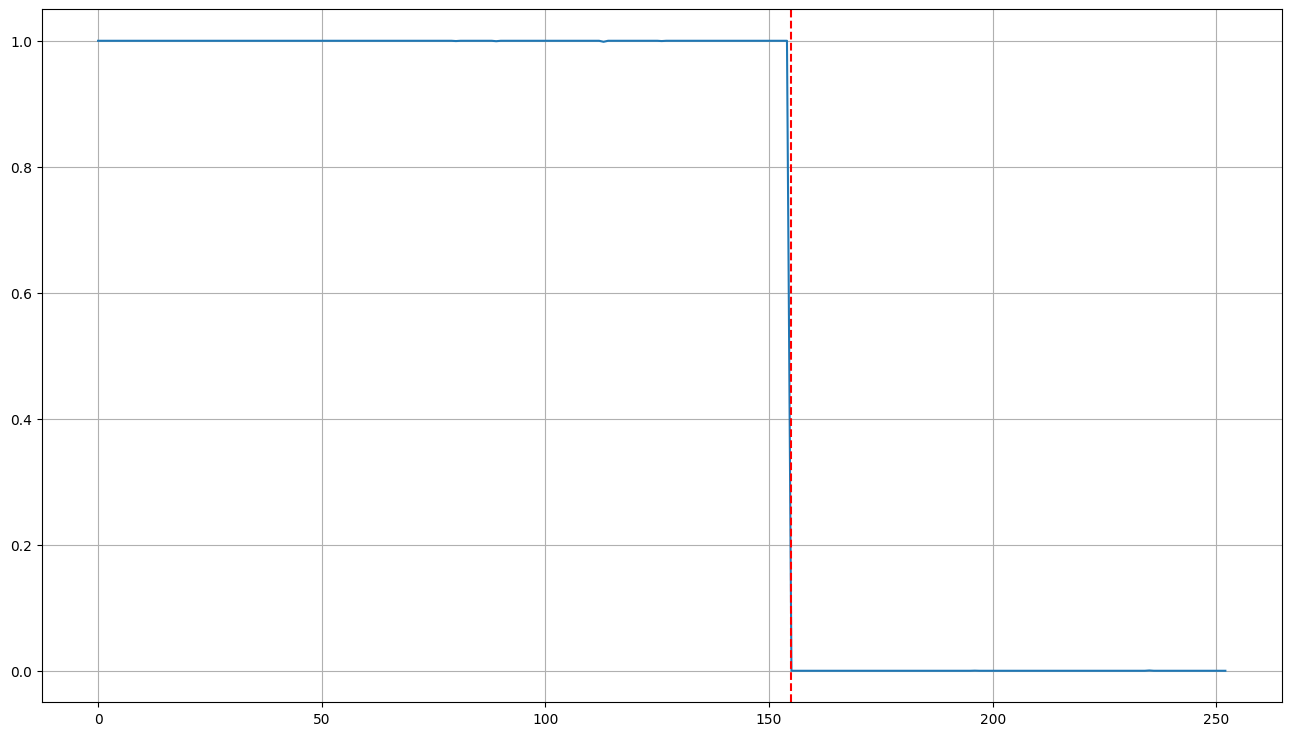

In [ ]:
plt.figure(figsize=(16, 9))

# Plot the outputs
plt.plot(outputs)

# Draw a vertical line at x = len(tumor)
plt.axvline(x=len(tumor), color='r', linestyle='--')

# Enable grid
plt.grid()

# Show the plot
plt.show()
